### motorPAINT processing: split by direction

MK Iwanski <br>
Universiteit Utrecht, Kaptein Lab <br>
2020-04-07

Based on the following code from RP Tas: 
* 20160929_ParticleSep_Ability to choose DriftCorrFile or both Raw_Python3_Dom-V1.x.py

In [16]:
# imports
import numpy as np

import sys as sys
import os
import tkinter as tk
from tkinter import filedialog

import matplotlib.pylab as plt
import time

In [17]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [18]:
root = tk.Tk()
root.withdraw()

raw = filedialog.askopenfilename(title = 'choose Linked Particle table OR drifcorrected Linked Particle Table format:.csv' )  #Detected particles that were DomLinked

basename = str(os.path.basename(raw))
savename = basename[:-4]
print (savename)
os.chdir(os.path.dirname(raw))   #set your working directoryimport os

drift = filedialog.askopenfilename(title = 'choose DriftCorrection file when drift correction is required ELSE cancel to continue as if already Drift Corrected')  #Driftcorrected file
Driftcorr_OnOff = 0

Results_DriftCorrected_wTracksS02C01R02


In [19]:
start_time = time.time()
original_time = start_time

#directory = "I:/TEMP/since 8-2/2016-03-01_DIV15_neurons/Roderick/particlesep"
#os.chdir(directory)   #set your working directory
try:
    DriftCorr = open(drift)        #Driftcorrected file by Dom on same file as infile should be csv
    driftfile = open(raw)   #DetectedParticles + DomLinked
except:
    print ('no driftcorrected file inserted, continue as if already driftcorrected')
    Driftcorr_OnOff = 1

no driftcorrected file inserted, continue as if already driftcorrected


In [20]:
if Driftcorr_OnOff == 0:
    line = DriftCorr.readline()

    d_nm = {}
    d_pix = {}

    #infile = open('filename')

    for line in DriftCorr:      
        frameNr = int(line.split(',')[0])
        driftxnm = float(line.split(',')[1])
        driftynm = float(line.split(',')[2])
        driftxpix = driftxnm / 65.
        driftypix = driftynm / 65.
        d_nm[frameNr] = (driftxnm,driftynm)
        d_pix[frameNr] = (driftxpix,driftypix)
    
    DriftCorr.close()

    print (max(d_nm))
    a = max(d_nm)
    b = min(d_nm)

    myfile = open(savename+'_DriftCorr.csv','a+')
    myfile.write(str(driftfile.readline()[:-1] + '\n'))

    for line2 in driftfile:
        frame = int(float(line2.split(',')[3]))
    
        if frame in d_nm.keys():
            xpix = float(line2.split(',')[1])+d_pix[frame][0]
            ypix = float(line2.split(',')[2])+d_pix[frame][1]
            xnm = float(line2.split(',')[4])+d_nm[frame][0]
            ynm = float(line2.split(',')[6])+d_nm[frame][1]
        elif frame < int(b) :
            xpix = float(line2.split(',')[1])+d_pix[b][0]
            ypix = float(line2.split(',')[2])+d_pix[b][1]
            xnm = float(line2.split(',')[4])+d_nm[b][0]
            ynm = float(line2.split(',')[6])+d_nm[b][1]
        else:
            xpix = float(line2.split(',')[1])+d_pix[a][0]
            ypix = float(line2.split(',')[2])+d_pix[a][1]
            xnm = float(line2.split(',')[4])+d_nm[a][0]
            ynm = float(line2.split(',')[6])+d_nm[a][1]        
        line3 = line2.replace((line2.split(',')[1]+','+line2.split(',')[2]+','+line2.split(',')[3]+','+line2.split(',')[4]+','+line2.split(',')[5] +','+line2.split(',')[6]), (str(xpix) + ',' + str(ypix) +','+line2.split(',')[3] + ',' + str(xnm) +','+line2.split(',')[5] + ',' + str(ynm)))
        #print(line2, '\n', line3)
    
#    line3 = line2[:-1] +','+ str(xnm) + ',' + str(ynm) + '\n'
        myfile.write(line3)

    myfile.close()
    
    print("--- %s seconds ---for driftcorrection" % (time.time() - start_time))

In [21]:
"""start track determination"""

try:
    if Driftcorr_OnOff == 0:    
        infile = open(savename+'_DriftCorr.csv', 'r')    #'all_Tracks20150528_purified_motors.csv', 'r'
        newsavename = savename+'_DriftCorr.csv'
    else:
        infile = open(basename, 'r')
        newsavename = basename
        
except IOError:
    print ('sorry file not found')
    sys.exit(1)
    
line = infile.readline()

try:
    line.split(',')[23]
except IOError:
    print('input has to be linked particle table')
    sys.exit(1)
    
#if str(line.split(',')[23]) == 'Track_ID':
#    print('Linked file inserted')         
#else:
#    print('input has to be linked particle table')
#    sys.exit(1)

In [22]:
# initialize variables
ddd={}
particleid = {}
l=[]
ll=[]
vallist = []
speedlist = []
disp = [] # displacement of the particle of its total track
degrees_list = []
tracklen =[]    #length of the track in nm

In [23]:
# parameters
""" 
note most motors walk about 3 steps in neurons with approx 700 nm/sec this results in a big loss of data when filtered based on 
the amount of steps. Additional we should be able to filter on speed since they all walk with approx the same speed. 
or drastically increase imaging time
stepsize of 4 does decrease the BGD dramatically but hwen low BGD you can choose for 3 as tracklength
If @3 can be double the amount of tracks but this can be BGD

"""
mintracklength = 3 # default @ 4 because you loose lots of BGD without afecting the tracks you see too much minimum length of the tracks you want to include minimum is 3 because you need at least two segments to see if your track is straight
maxtracklength = 200 #maximum length of tracks you want to include
minspeed = 100 #nm/s included in the vectormap
maxspeed = 1500 #nm/s included in the vectormap #was at 15000 - this is NOT currently used
exptime = 0.060 # sec was at 0.1
max_angle = 80# maximum angle that can be observed in a track default 75

In [24]:
""" Here the file is read line by line and the parameters trackid (tid) particleid (pid) are determined with their predicted 
x and y coordinate Then these numbers together in a library are appended to a list and this list is sorted based on tid and pid
 """

start_time = time.time()

while True:
    line = infile.readline()
    
    if line:      
        tid = int(line.split(',')[23])  #trackid
        pid = int(line.split(',')[24])  #particleid
        x = float(line.split(',')[4])
        y = float(line.split(',')[6])
        trlen = int(line.split(',')[25])
        xy = (x,y)
        
#        print tid, pid, xy
        if tid in ddd.keys():
        # append the new number to the existing array at this slot
            ddd[tid].append([pid,xy])
        else:
        # create a new array in this slot
            ddd[tid] = [[pid,xy]]
            
    if not line:
        break
infile.close()

#print (ddd)
#print l
print (len(ddd))
#print (ll)
#print lk

print("--- %s seconds ---Tracks Assigned" % (time.time() - start_time))

390562
--- 11.85004210472107 seconds ---Tracks Assigned


In [25]:
red = []
blue =[]
green =[]
yellow =[]
LocRed = []  # #length of all tracks in red
LocYellow = []  
LocBlue =  []
LocGreen = []

redvalid = []
greenvalid =  []
bluevalid =[]
yellowvalid =[]

In [26]:
for i in range(0,len(ddd)): #len(l) is the length of all lines #here calculate dx,dy for all things with same tid in list l

    start_time = time.time()
    
#    if z == j: #loop over sorted list and look for first value tid in the dictionary. see if it equals the counter: if the counter is already there--> fill in the values of this tid
    if i in ddd.keys() and mintracklength <= len(ddd[i]) <= maxtracklength:
        z = (ddd[i])
#        print (z)
#        print (len(z), z[1])
        for j in range(0,len(z)):
#            print (z[j][0], z[j][1])
            vallist.append(z[j][1])
            
            if len(vallist) == 2: 
                vector1 = np.array([vallist[-1][0]-vallist[-2][0], vallist[-1][1]-vallist[-2][1], 0])   #calculate vector of particle track between this frame and the previous
                x_modulus = np.sqrt((vector1*vector1).sum())    # calculate the distance traveled in the current segment of the track
                tracklen.append(x_modulus)  #add the current displacement to a displacement list for this track
            
            elif len(vallist)>2:  
                vector1 = np.array([vallist[-1][0]-vallist[-2][0], vallist[-1][1]-vallist[-2][1], 0])   #calculate vector of particle track between this frame and the previous
                x_modulus = np.sqrt((vector1*vector1).sum())    # calculate the distance traveled in the current segment of the track
                tracklen.append(x_modulus)  #add the current displacement to a displacement list for this track
           
            
                vector2 = np.array([vallist[-2][0]-vallist[-3][0], vallist[-2][1]-vallist[-3][1], 0])   #calculate previous vector to calculate the scalar/dot product
                dot = np.dot(vector1 , vector2) #calculate the dot product
            
                y_modulus = np.sqrt((vector2*vector2).sum())
                cosine = dot /x_modulus/y_modulus  #calculate the cosine between the current segment of the track and the previous should be below 90 degrees otherwise the particle will turn back and it will be a reversal or a non processive track
                angle = np.arccos(cosine)
                degrees = angle * 360 / 2 / np.pi
                degrees_list.append(degrees)
            
        if max(degrees_list) < max_angle:      
            speed = (sum(tracklen))/(len(tracklen))/exptime         #velocity um/s of motor based on last coordinate and first coordinate divided by the time(amount of frames it took to get there frame is 100ms generally)           
            x0 = float(vallist[0][0])
            y0 = float(vallist[0][1])
            dx = (float(vallist[-1][0])- x0) #final displacement in x based on first and last point
            dy = (float(vallist[-1][1])- y0) #final displacement in y based on first and last point
            
#                print 'plt'
            if dy < 0 and dx > 0  and speed > minspeed:    #Dom inverts the pixels for some reason so this can be inverted
                color = 'r'
                LocRed.append(len(vallist))
                redvalid.append(i) #add valid trackno for these red values 
                
            elif dy > 0 and dx < 0  and speed > minspeed:
                color = 'g'
                LocGreen.append(len(vallist))
                greenvalid.append(i)
            
            elif dy < 0 and dx < 0  and speed > minspeed:
                color = 'y'
                LocYellow.append(len(vallist))
                yellowvalid.append(i)
                
            elif dy > 0 and dx > 0 and speed > minspeed: #added extra conditions because maybe tracks have no net displacement
                color = 'b'
                LocBlue.append(len(vallist))
                bluevalid.append(i)

            speedlist.append(speed)      
        del vallist[:] #clear the value list for the next trackid
        del degrees_list[:]
        del tracklen[:]

print("--- %s seconds ---tracksFiltered" % (time.time() - start_time))

--- 0.00010085105895996094 seconds ---tracksFiltered


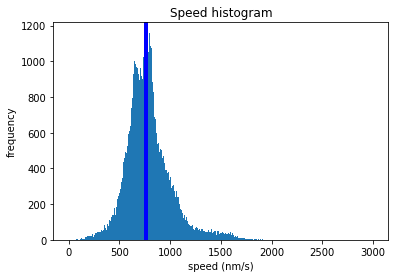

58647 9060 16363 10680 22527
total amount of localizations is red: 40475 Green: 73268 Blue: 47383 Yellow: 102423


In [27]:
f = open(savename + 'speed.txt','w')
f.write("\n".join(map(lambda x: str(x), speedlist)))
f.close()

plt.figure()
plt.hist(speedlist, range = [0., 3000.], bins = 400,)
plt.axvline(np.median(speedlist), color = 'b', linewidth = 4)
plt.title("Speed histogram")
plt.xlabel("speed (nm/s)")
plt.ylabel("frequency")

plt.show()

print (len(speedlist), len(LocRed), len(LocGreen), len(LocBlue), len(LocYellow))
print ('total amount of localizations is' , 'red:',sum(LocRed), 'Green:',sum(LocGreen), 'Blue:',sum(LocBlue), 'Yellow:',sum(LocYellow))


In [28]:
infile2 = open(newsavename, 'r')
myfile_yellow = open(savename +'_LT.csv','a+')
myfile_green =open(savename +'_LB.csv','a+')
myfile_blue =open(savename +'_RB.csv','a+')
myfile_red =open(savename +'_RT.csv','a+')

title = infile2.readline()[:-1]
myfile_red.write(title + '\n')
myfile_green.write(title + '\n')
myfile_blue.write(title + '\n')
myfile_yellow.write(title + '\n')

redvalid2 = np.array(redvalid)
greenvalid2=np.array(greenvalid)
yellowvalid2 = np.array(yellowvalid)
bluevalid2 = np.array(bluevalid)

for line2 in infile2:
    tid = line2.split(',')[23]

    if int(tid) in redvalid2:
        line3 = line2[:-1] + '\n'
        myfile_red.write(line3)
    elif int(tid) in greenvalid2:
        line3 = line2[:-1] + '\n'
        myfile_green.write(line3)
    elif int(tid) in bluevalid2:  
        line3 = line2[:-1] + '\n'
        myfile_blue.write(line3)
    elif int(tid) in yellowvalid2:  
        line3 = line2[:-1] + '\n'
        myfile_yellow.write(line3)
   
myfile_red.close()
myfile_green.close()
myfile_blue.close()
myfile_yellow.close()
infile2.close()
    
print("--- %s seconds ---" % (time.time() - original_time))

--- 71.86763095855713 seconds ---
